# Uncovering Brand Activity, Popularity and Emotions on Facebook

### Main questions:
- What does Hasaki post on Facebook?
- How do people react to Hasaki posts?
- What do Hasaki's Facebook audience say about Hasaki?
- What are the emotions expressed by Hasaki's Hasaki audience?

### Process

<img src="Imgs/Process.png">


In [1]:
import pandas as pd
import re
import nltk
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud
import itertools
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")

In [2]:
from underthesea import text_normalize, word_tokenize, sentiment,pos_tag

In [3]:
df_posts = pd.read_csv("Data/hasaki.csv").dropna()
df_posts['posted_on'] = pd.to_datetime(df_posts['posted_on'])
df_posts.head()

id                    name  shares  likes  loves  wow  cares  \
0  839591221544380  Hasaki Beauty & Clinic       0      1      0    0      0   
1  839675988202570  Hasaki Beauty & Clinic       0      1      0    0      0   
2  839612508208918  Hasaki Beauty & Clinic       0      2      0    0      0   
4  839611824875653  Hasaki Beauty & Clinic       0      2      0    0      0   
5  839646541538848  Hasaki Beauty & Clinic       0      3      0    0      0   

   sad  angry  haha  reactions_count  comments  \
0    0      0     0                1         2   
1    0      0     0                1         0   
2    0      0     0                2         0   
4    0      0     0                2         0   
5    0      0     0                3         0   

                                             content  \
0   CẬP NHẬT PHIÊN BẢN MỚI CỦA PHIẾU VOUCHER TẶNG...   
1  #𝗡𝗼𝘄𝐅𝗿𝗲𝗲𝟮𝗛 Trễ Tặng 100K - 172 Chi NhánhTINH C...   
2  #𝗡𝗼𝘄𝐅𝗿𝗲𝗲𝟮𝗛 Trễ Tặng 100K - 172 Chi NhánhMASCAR...   
4  #𝗡𝗼𝘄𝐅𝗿𝗲𝗲𝟮𝗛 Trễ Tặng 100K - 172 Chi NhánhTOP 5 ...   
5  #𝗡𝗼𝘄𝐅𝗿𝗲𝗲𝟮𝗛 Trễ Tặng 100K - 172 Chi NhánhRAU MÁ...   

                   posted_on video  \
0 2024-03-21 22:45:00.463292    []   
1 2024-03-21 21:45:08.266367    []   
2 2024-03-21 21:45:08.504032    []   
4 2024-03-21 20:45:09.123058    []   
5 2024-03-21 19:45:09.405133    []   

                                               image  \
0  https://scontent.fsgn2-9.fna.fbcdn.net/v/t39.3...   
1  https://scontent.fsgn2-7.fna.fbcdn.net/v/t39.3...   
2  https://scontent.fsgn2-9.fna.fbcdn.net/v/t39.3...   
4  https://scontent.fsgn2-8.fna.fbcdn.net/v/t39.3...   
5  https://scontent.fsgn2-7.fna.fbcdn.net/v/t39.3...   

                                            post_url  
0  https://www.facebook.com/Hasaki.vn/posts/83959...  
1  https://www.facebook.com/Hasaki.vn/posts/83967...  
2  https://www.facebook.com/Hasaki.vn/posts/83961...  
4  https://www.facebook.com/Hasaki.vn/posts/83961...  
5  https://www.facebook.com/Hasaki.vn/posts/83964...

In [4]:
df_comments = pd.read_excel("Data\Hasaki_comments_output.xlsx").dropna()
df_comments = df_comments.rename(columns={'comments_message':'content'})
df_comments['comment_created_time'] = pd.to_datetime(df_comments['comment_created_time'])
df_comments.head()

comment_id      comment_created_time  comments_like  \
0  844612147708954_1033344711696609 2024-03-29 02:05:35+00:00              0   
1   844612147708954_930924992072393 2024-03-29 02:46:27+00:00              0   
2  844612147708954_1114114726403062 2024-03-29 04:36:07+00:00              0   
3   844612147708954_794406212555426 2024-03-29 05:06:16+00:00              1   
4   844612147708954_984452966641510 2024-03-29 09:06:27+00:00              0   

   comments_love  comments_wow  comments_haha  comments_sad  comments_angry  \
0              0             0              0             0               0   
1              0             0              0             0               0   
2              0             0              0             0               0   
3              0             0              0             0               0   
4              0             0              0             0               0   

                                             content  comment_count  
0  𝐂𝐍 𝟏𝟕𝟑: 2203 Hùng Vương, Phường Cam Lợi, TP. C...              0  
1                Mua ở tại cửa hàng có giá này ko ạ?              1  
2                                               ♥️♥️              0  
3                                     Đỗ Huỳnh Ái My              1  
4                                          Ngọc Linh              0

# Feature extraction

In [5]:
def clean_text(text):
    text = str(text).lower()  # Lowercase words
    # text = ' '.join(text.split())
    text = text.strip()
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"[Ââ€™œ¢\t]","", text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # tokenize single comment
    tokens = nltk.word_tokenize(text)
    return tokens

In [6]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [7]:
def get_hashtags(text):
    hashtags = re.findall(r"#(\w+)", text)
    return hashtags

In [8]:
def execute_pipeline (dataframe):
    dataframe['content'] = dataframe['content'].astype(str)
    #Get hashtags
    dataframe ['hashtags'] = dataframe.apply(lambda x:get_hashtags (x['content']),axis=1)
    #Pre-process
    # dataframe['content'] = dataframe.apply(lambda x:clean_text (x['content']),axis=1)
    dataframe['content'] = dataframe.apply(lambda x:remove_emojis (x['content']),axis=1)
    return (dataframe)

df_posts = execute_pipeline(df_posts)
df_comments = execute_pipeline(df_comments)

In [9]:
def remove_https_links(text):
    # Regular expression pattern to match HTTPS URLs
    url_pattern = r'https?://\S+'
    # Replace found URLs with an empty string
    cleaned_text = re.sub(url_pattern, '', text)
    return cleaned_text


In [10]:
stop_words = {'hasaki', 'https', 'hasaki vn', 'hasaki clinic', 'hasakiclinic', 'hasaki_clinic', 'có', 'và', 'ạ', 'tại Hasaki', 'b'}

def remove_stop_words_from_text(text):
    # Normalize the text to lower case to handle case insensitivity
    words = text.lower().split()
    # Filter words to remove any that are in the stop words set
    filtered_words = [word for word in words if word not in stop_words]
    # Join the filtered words back into a single string
    cleaned_text = ' '.join(filtered_words)
    return cleaned_text

df_comments['content'] = df_comments['content'].apply(remove_stop_words_from_text)
df_posts['content'] = df_posts['content'].apply(remove_stop_words_from_text)


text normalize

In [11]:
df_posts['content'] = df_posts['content'].apply(text_normalize)
df_comments['content'] = df_comments['content'].apply(text_normalize)


word segmentation

In [12]:
df_comments['content'] = df_comments['content'].apply(remove_https_links)
df_posts['content'] = df_posts['content'].apply(remove_https_links)

In [13]:

df_comments['word_token'] = df_comments['content'].apply(word_tokenize)
df_posts['word_token'] = df_posts['content'].apply(word_tokenize)

In [14]:
# df_posts['content'] = df_posts['content'].apply(pos_tag)
# df_comments['content'] = df_comments['content'].apply(pos_tag)

# Text analysis

## content

### full posts

In [15]:
# Join tokens into single strings for each row
tokens_str =df_posts['word_token'].apply(lambda tokens: ' '.join(tokens))
long_string = ','.join(tokens_str.values)

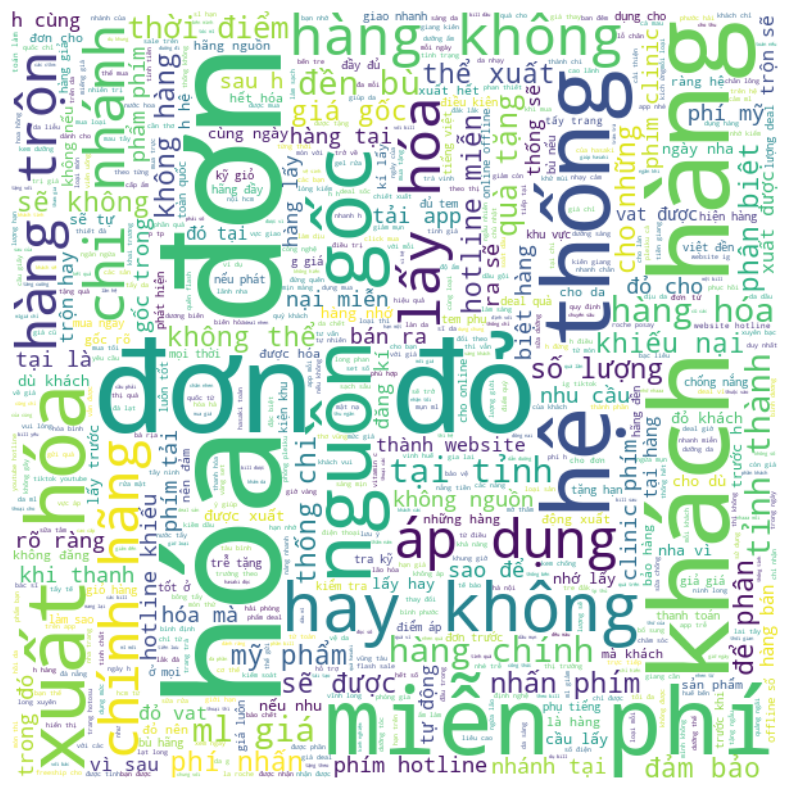

In [16]:
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=600, height=600)
wordcloud.generate(long_string)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
# Join tokens into single strings for each row
tokens_str =df_comments['word_token'].apply(lambda tokens: ' '.join(tokens))
long_string = ','.join(tokens_str.values)

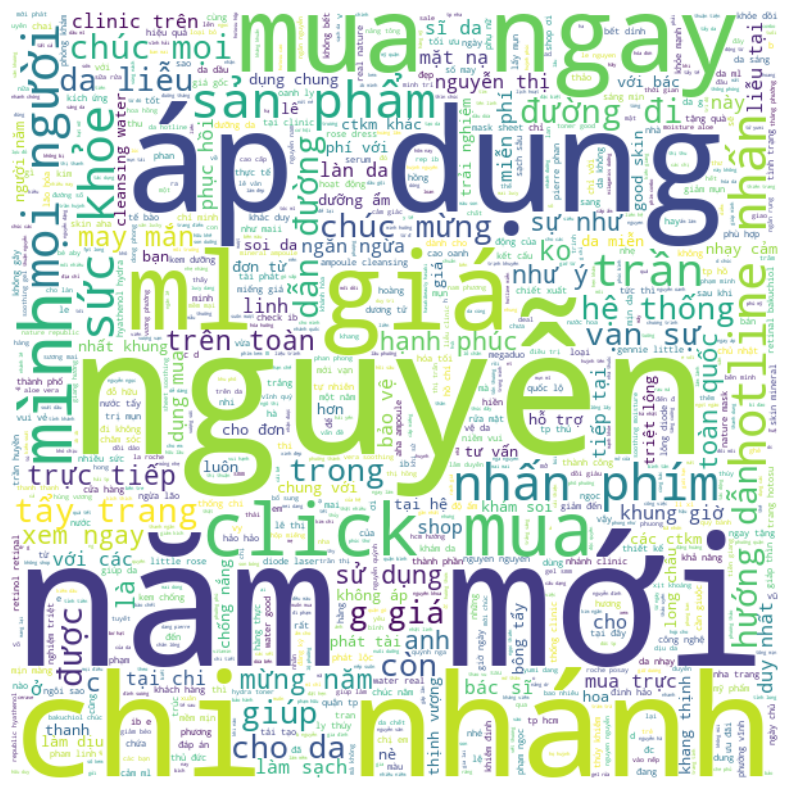

In [18]:
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=600, height=600)
wordcloud.generate(long_string)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### top 20

top 20 post có lượt tương tác cao nhất

:v nhìn là biết hack data như đb

In [19]:
df_posts_top20 = df_posts.sort_values(by='reactions_count', ascending=False).head(20)
df_posts_top20

id  \
532   pfbid02qYyqyU7TdnDV2YcyEcM2nXJ2PXug6Y2zq8xFRD1...   
402   pfbid02Jah8AkbHyG3Y8kFqty3LgNxAaBwdgmgXR1m2kyM...   
277   pfbid0LsPFBT8jDFehoj1rQ6w1pa7Tmvr8oX9izZEw87e7...   
1162  pfbid05FvWM8dJ6mpZcmVaTFMqE7uZrPWqbmbtGb8uY4sx...   
762   pfbid028zvT5NkDVo4P26Thwg8An5sUzJqEuykpKdunQnH...   
414   pfbid0228R2f5MhidnWxwFe3WdZPdBuCj2s5TN8sNN2F55...   
573   pfbid09ck875CTS7c9QwgzmRqvpW6AubVBs2EBrS9Ad36w...   
142   pfbid0227efYRSBNtMHuVNVRCjJLphZEaiRxmCEJ3Ahgd9...   
1148  pfbid02GQtAcWn2Kz4jGMBtEmVZQ731NGW5DhzcT6nC5xb...   
1214  pfbid02TC13naszKKJAY87FUfTet9BJofLmm95f47r7K46...   
782   pfbid0igFnpkUTb9wNngPj8wJvZJ7cC2fXTbtj5ho3GQzC...   
968   pfbid0f4u8Z11Q4iabfFY33icqpATGz5Qi9FCuUU5hQ6Bj...   
128   pfbid0dLyNio4iSgBw1zDMCB4utUdvdU7svbEcBtdS73w8...   
692   pfbid0nW4XJNLj7Dkh84aLQYArx8XN2ty3UQuzN6MQVh6L...   
555   pfbid021eg9RbewurAHpKBjxCDktxs7XVJideTmo86fqRW...   
586   pfbid02qW2oCm6Sj8Umo6PWNDX1JHEJE4PZqQEj5ayoDwq...   
1160  pfbid0CY8UGeS1B4BLijCUzkihQg7YDWkbX83s4Mq7n5Mk...   
903   pfbid02gnpsnTL7vwkTLn1NYJ7BKpZY9Ua4jSBTnhMwMF9...   
924   pfbid02gdsUPqSbocQmrU2HpgEqajFRnBu6R9rk7maNt2Q...   
1147  pfbid0ChrDLgbwoQHjZtuEfhJjECqVK6Y3V9aPiitYrBst...   

                        name  shares  likes  loves  wow  cares  sad  angry  \
532   Hasaki Beauty & Clinic    1500   1400      0    0      0    0      0   
402   Hasaki Beauty & Clinic    1200   1100      0    0      0    0      0   
277   Hasaki Beauty & Clinic    1200   1100      0    0      0    0      0   
1162  Hasaki Beauty & Clinic      31    849      0    0      0    0      0   
762   Hasaki Beauty & Clinic     617    831      0    0      0    0      0   
414   Hasaki Beauty & Clinic     782    767      0    0      0    0      0   
573   Hasaki Beauty & Clinic     725    721      0    0      0    0      0   
142   Hasaki Beauty & Clinic    1200    639      0    0      0    0      0   
1148  Hasaki Beauty & Clinic    1200    627      0    0      0    0      0   
1214  Hasaki Beauty & Clinic       6    612      0    0      0    0      0   
782   Hasaki Beauty & Clinic     409    598      0    0      0    0      0   
968   Hasaki Beauty & Clinic     464    587      0    0      0    0      0   
128   Hasaki Beauty & Clinic     593    585      0    0      0    0      0   
692   Hasaki Beauty & Clinic     514    564      0    0      0    0      0   
555   Hasaki Beauty & Clinic     531    552      0    0      0    0      0   
586   Hasaki Beauty & Clinic     550    544      0    0      0    0      0   
1160  Hasaki Beauty & Clinic     350    536      0    0      0    0      0   
903   Hasaki Beauty & Clinic     373    531      0    0      0    0      0   
924   Hasaki Beauty & Clinic       6    516      0    0      0    0      0   
1147  Hasaki Beauty & Clinic      10    469     38    0      0    0      0   

      haha  reactions_count  comments  \
532      0             1400      1500   
402      0             1100      1100   
277      0             1100      1300   
1162     0              849        76   
762      0              831       831   
414      0              767       711   
573      0              721       717   
142      0              639      1200   
1148     0              627      1400   
1214     0              612        10   
782      0              598       607   
968      0              587       584   
128      0              585       581   
692      0              564       552   
555      0              552       506   
586      0              544       526   
1160     0              536       537   
903      0              531       541   
924      0              516        12   
1147     0              507        96   

                                                content  \
532   # trễ tặng 100 k - 165 chi nhánh [ minigame ] ...   
402   # trễ tặng 100 k - 167 chi nhánh [ minigame b ...   
277   # trễ tặng 100 k - 169 chi nhánh [ minigame ] ...   
1162  trị sẹo rỗ hiệu quả lấy lại vẻ mịn màng cho là...   
762   # trễ tặng 

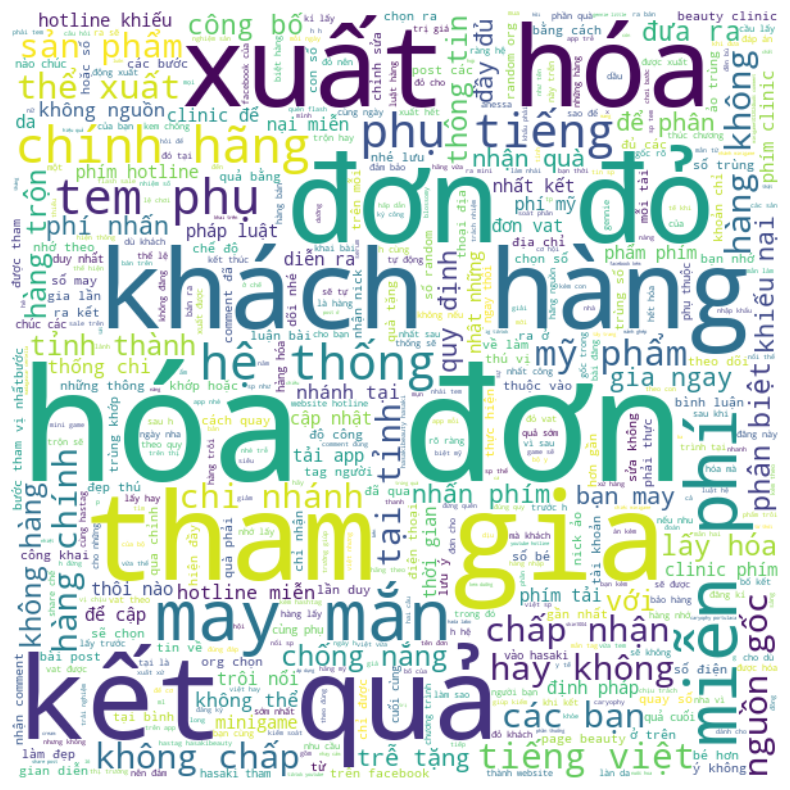

In [20]:
# Join tokens into single strings for each row
tokens_str =df_posts_top20['word_token'].apply(lambda tokens: ' '.join(tokens))
long_string = ','.join(tokens_str.values)
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=600, height=600)
wordcloud.generate(long_string)

# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
def print_verbatims (df, nb_verbatim, keyword):
    verbatims = df [df['content'].str.contains (keyword)] 
    for i,text in verbatims.head(nb_verbatim).iterrows():
        print (text['content'])

In [22]:
print_verbatims(df_posts, 20, '\\bmiễn phí\\b')


cập nhật phiên bản mới của phiếu voucher tặng bạn tại các shop hasaki ! ! khách yêu thân mến ! với mong muốn mang đến cho bạn thêm nhiều trải nghiệm làm đẹp tuyệt vời tại clinic , phòng khám xin cập nhật đến bạn thông tin phiên bản mới của phiếu voucher dịch vụ sẽ được nhận khi mua hàng tại các shop hasaki : thêm dịch vụ mới , ưu đãi mới . thay thế cho chương trình cũ ( hiện đã ngừng áp dụng ) . cách sử dụng phiếu voucher phiên bản mới : tương tự voucher ưu đãi phiên bản cũ , khách hàng xé phần voucher dịch vụ tương ứng mà mình muốn trải nghiệm hoặc đưa toàn bộ phiếu ưu đãi cho nhân viên tư vấn tại quầy . lưu ý : hiện tại phiên bản cũ của phiếu voucher dịch vụ đã không còn áp dụng tại tất cả chi nhánh clinic trên toàn quốc . liên hệ clinic để được tư vấn chi tiết > inbox : m.me/hasakispa > hotline miễn phí : 1800 6324 - nhấn phím 2 thời gian hoạt động của hệ thống phòng khám da liễu clinic : - từ thứ 2 đến chủ nhật ( phiên nhận khách cuối là 19 h ) ( * ) riêng chi nhánh 177 ba cu , tp 

In [23]:
print_verbatims(df_comments, 20, '\\bgiá\\b')

mua ở tại cửa hàng giá này ko ạ ?
1 liệu trình triệt lông chân vĩnh viễn giá bao nhiêu vậy
4.4 sống chất - chồng chất deal ngon mã giảm giá 100 ka từ beauty & clinic >>  ( áp dụng cho shopee video ) mẫu mới hôm nay >>  ( xem ngay ) mã toàn sàn : thanhmgg.com
kem nền maybelline mịn nhẹ kiềm dầu chống nắng # 110 30 ml giá : # 163 k click mua ngay :  -------------- + khả năng kiềm dầu tốt , cho lớp nền luôn mịn lì . + độ che phủ trung bình - cao , che phủ khuyết điểm lỗ chân lông tốt . + hiệu ứng finish mịn nhẹ , tự nhiên , thoáng da . + bảng màu với 12 tông , phù hợp cho mọi tông da khác nhau . + kem nền lý tưởng cho da thường , da hỗn hợp da dầu . + bao bì cải tiến với đầu nhấn tiện lợi . --------------------------- hotline : 1800 6324 - nhấn phím 1
kem nền maybelline mịn nhẹ kiềm dầu chống nắng # 112 natural ivory 30 ml giá : # 163 k click mua ngay :  ------------------------ + kiềm dầu tốt , cho lớp nền luôn mịn lì + độ che phủ trung bình - cao , che phủ khuyết điểm lỗ chân lông tốt .

In [24]:
print_verbatims(df_comments, 20, '\\bnăm mới\\b')

8-3-6 7-2-5 4-1-9 chúc mọi người năm mới nhiều sức khỏe , luôn bình an may mắn trong mọi việc - 287 nga nguyen nguyễn nam phương vân vân lucky
8-3-6 7-2-5 4-1-9 số may mắn : 246 hoa đào nở , chim én về , mùa xuân lại đến . chúc mọi người một năm mới : nghìn sự như ý , vạn sự như mơ , triệu sự bất ngờ , tỷ lần hạnh phúc . sương mai dong phong như maii
8-3-6 7-2-5 4-1-9 số may mắn : 293 chúc mọi người năm mới khỏe mạnh , tinh thần phấn chấn sự nghiệp tấn tới , phơi phới mang tiền về đầu năm xum vầy , vận may đủ đầy vạn sự hanh thông , mọi điều suôn sẻ pham linh mai mai lucy dang
8-3-6 7-2-5 4-1-9 số may mắn : 352 năm mới 2024 đến rồi . chúc mọi người năm mới . vạn sự bình an . tài lộc đầy tràn . happy new year 2024 ! ban mai thanh thanh như maii
8-3-6 7-2-5 4-1-9 số may mắn : 401 chúc mọi người năm mới khỏe mạnh , tinh thần phấn chấn sự nghiệp tấn tới , phơi phới mang tiền về đầu năm xum vầy , vận may đủ đầy vạn sự hanh thông , mọi điều suôn sẻ phan phong mei dang nguyen nguyen
đáp án 8-

## Hashtags

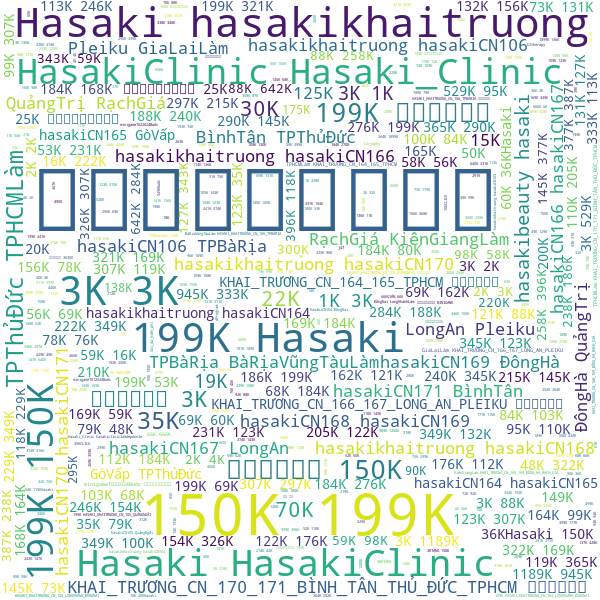

In [25]:
keywords = df_posts['hashtags']
flat_list = [item for sublist in keywords for item in sublist]
long_string = ','.join(flat_list)
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=600, height=600)
wordcloud.generate(long_string)
wordcloud.to_image()

hastag từ comment toàn là từ hasaki nên cx éo có ý nghĩa mẹ gì hết

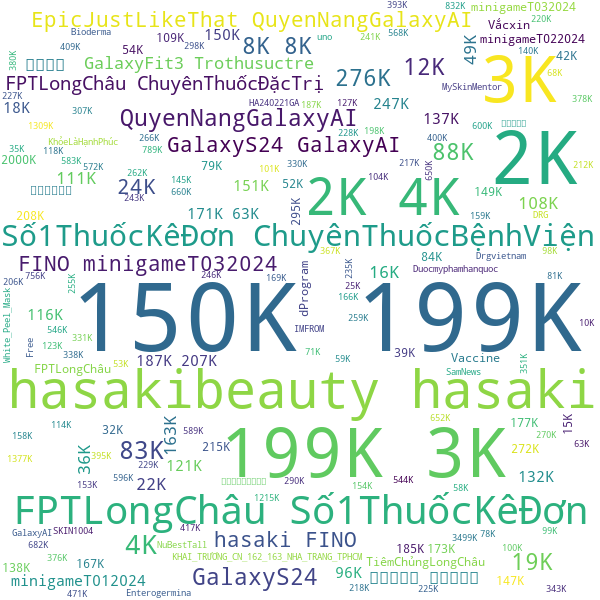

In [26]:
keywords = df_comments['hashtags']
flat_list = [item for sublist in keywords for item in sublist]
long_string = ','.join(flat_list)
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=600, height=600)
wordcloud.generate(long_string)
wordcloud.to_image()

# Time series

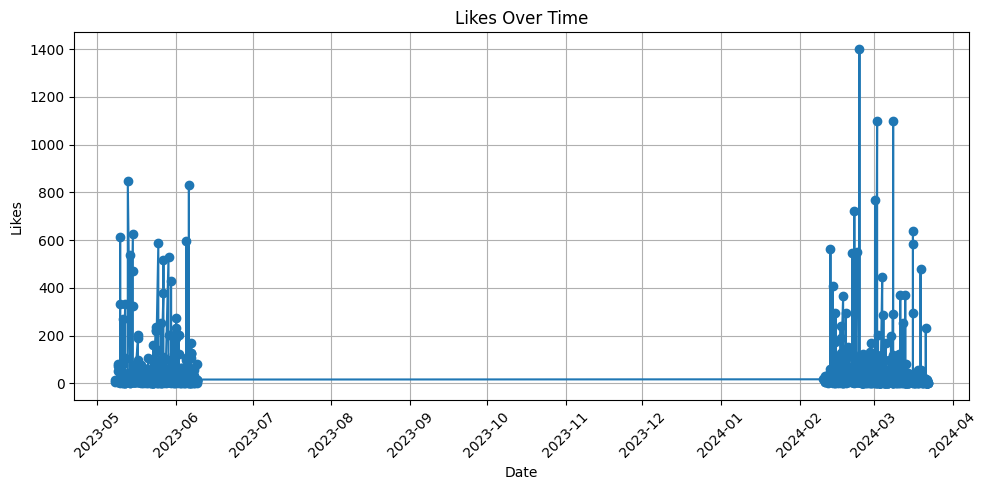

In [27]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(df_posts['posted_on'], df_posts['likes'], marker='o', linestyle='-')  # Line plot
plt.title('Likes Over Time')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Likes')  # Y-axis label
plt.grid(True)  # Show grid
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Auto-adjusts the plot parameters to give it padding
plt.show()  # Display the plot


In [28]:
# Create a subplot with 3 rows
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add each metric to the subplot
fig.add_trace(
    go.Scatter(x=df_posts['posted_on'], y=df_posts['likes'], name='Likes', mode='lines+markers'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_posts['posted_on'], y=df_posts['shares'], name='Shares', mode='lines+markers'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df_posts['posted_on'], y=df_posts['comments'], name='Comments', mode='lines+markers'),
    row=3, col=1
)

# Update x-axis and y-axis labels
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Likes", row=1, col=1)
fig.update_yaxes(title_text="Shares", row=2, col=1)
fig.update_yaxes(title_text="Comments", row=3, col=1)

# Update layout and display the plot
fig.update_layout(height=600, width=1000, title_text="Metrics Over Time")
fig.show()


# Sentiment analysis

In [29]:
df_comments['sentiment'] = df_comments['content'].apply(sentiment)

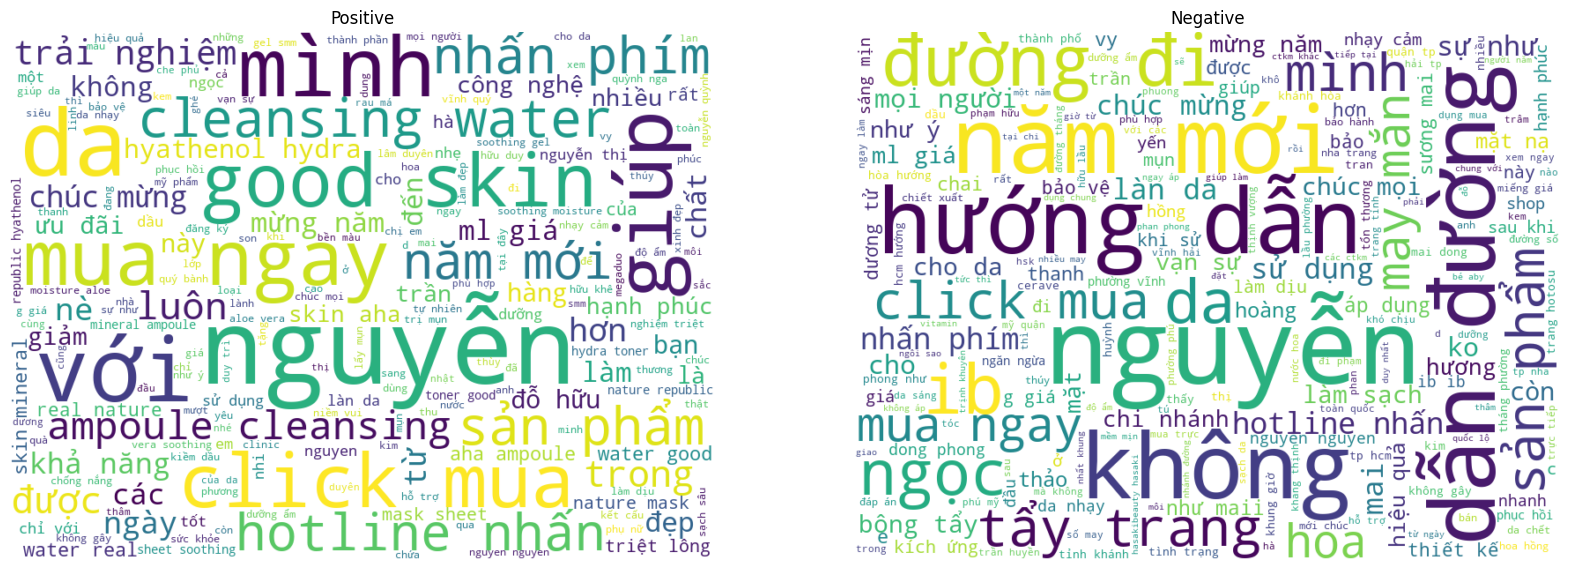

In [30]:

# Print all of the Negative tweets
neg_reviews = df_comments[df_comments["sentiment"] == "negative"]

allwords = ' '.join([content for content in neg_reviews["content"]] )
word_Cloud_neg = WordCloud(width = 800, height = 600, background_color = "white",
               random_state = 21, max_font_size = 119).generate(allwords)

# Print all of the Negative tweets
pos_reviews = df_comments[df_comments["sentiment"] == "positive"]

allwords = ' '.join([content for content in pos_reviews["content"]] )
word_Cloud_pos = WordCloud(width = 800, height = 600, background_color = "white",
               random_state = 21, max_font_size = 119).generate(allwords)

# Print all of the Negative tweets
# neu_reviews = df_comments[df_comments["sentiment"].isna()]

# allwords = ' '.join([content for content in neu_reviews["content"]] )
# word_Cloud_neu = WordCloud(width = 800, height = 600, background_color = "white",
#                random_state = 21, max_font_size = 119).generate(allwords)

fig, (a1,a2) = plt.subplots(1,2, figsize = (20,10))
a1.imshow(word_Cloud_pos, interpolation = "bilinear")
# a2.imshow(word_Cloud_neu, interpolation = "bilinear")
a2.imshow(word_Cloud_neg, interpolation = "bilinear")
a1.axis('off')
# a2.axis('off')
a2.axis('off')
a1.set_title("Positive")
# a2.set_title("Neutral")
a2.set_title("Negative")
# plt.figure(figsize=(30,10))
# plt.tight_layout(pad=0)
plt.show()

In [31]:
fig = px.bar(df_comments['sentiment'].value_counts(), text_auto=True)
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

# Topic modeling

In [32]:
import cohere
import numpy as np
import joblib
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import umap
import seaborn as sns
import altair as alt
from sklearn.cluster import KMeans
from bertopic import BERTopic   
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from pyvi.ViTokenizer import tokenize
from yellowbrick.cluster import KElbowVisualizer



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
binary_path: c:\Users\defaultuser0.LAPTOP-POTNR7PE\AppData\Local\Programs\Python\Python311\Lib\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll
CUDA SETUP: Loading binary c:\Users\defaultuser0.LAPTOP-POTNR7PE\AppData\Local\Programs\Python\Python311\Lib\site-packages\bitsandbytes\cuda_setup\libbitsandbytes_cuda116.dll...


In [33]:
cmt_embeddings = joblib.load('Assets/cmt_embeddings.pkl')
content_embeddings = joblib.load('Assets/content_embeddings.pkl')

In [34]:

sentence_model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
df_comments =  df_comments.dropna()
# sentences = [tokenize(sentence) for sentence in df_comments['content']]
# embeddings = sentence_model.encode(sentences)

# joblib.dump(embeddings, 'Assets/cmt_embeddings_phobert.pkl')
# joblib.dump(sentences, 'Assets/sentences_phobert.pkl')


No sentence-transformers model found with name VoVanPhuc/sup-SimCSE-VietNamese-phobert-base. Creating a new one with MEAN pooling.


In [35]:

embeddings = joblib.load('Assets/cmt_embeddings_phobert.pkl')
sentences = joblib.load('Assets/sentences_phobert.pkl')

For n_clusters = 2, silhouette score is 0.11791662126779556
For n_clusters = 3, silhouette score is 0.12259078025817871
For n_clusters = 4, silhouette score is 0.12711350619792938
For n_clusters = 5, silhouette score is 0.12504863739013672
For n_clusters = 6, silhouette score is 0.1498253047466278
For n_clusters = 7, silhouette score is 0.1550648957490921
For n_clusters = 8, silhouette score is 0.16249403357505798
For n_clusters = 9, silhouette score is 0.16544084250926971


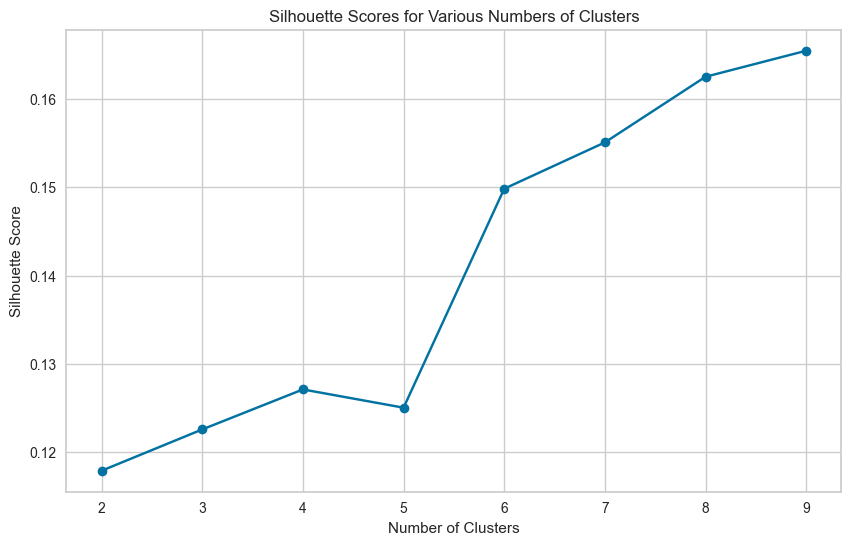

In [36]:
#Silhouette Score
scores = []
for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    preds = clusterer.fit_predict(embeddings)
    centers = clusterer.cluster_centers_

    score = silhouette_score(embeddings, preds)
    scores.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

# Number of clusters
cluster_range = range(2, 10)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

SSE for k=1: 97181.0546875
SSE for k=2: 85696.7109375
SSE for k=3: 81163.171875
SSE for k=4: 77486.703125
SSE for k=5: 74799.1328125
SSE for k=6: 72092.53125
SSE for k=7: 70131.1328125
SSE for k=8: 68964.1953125
SSE for k=9: 68107.6640625
SSE for k=10: 67154.59375
SSE for k=11: 66619.0625
SSE for k=12: 65718.71875
SSE for k=13: 65011.6015625
SSE for k=14: 64650.8203125
SSE for k=15: 64073.15625
SSE for k=16: 63485.80078125
SSE for k=17: 62670.546875
SSE for k=18: 62561.28125
SSE for k=19: 62011.5


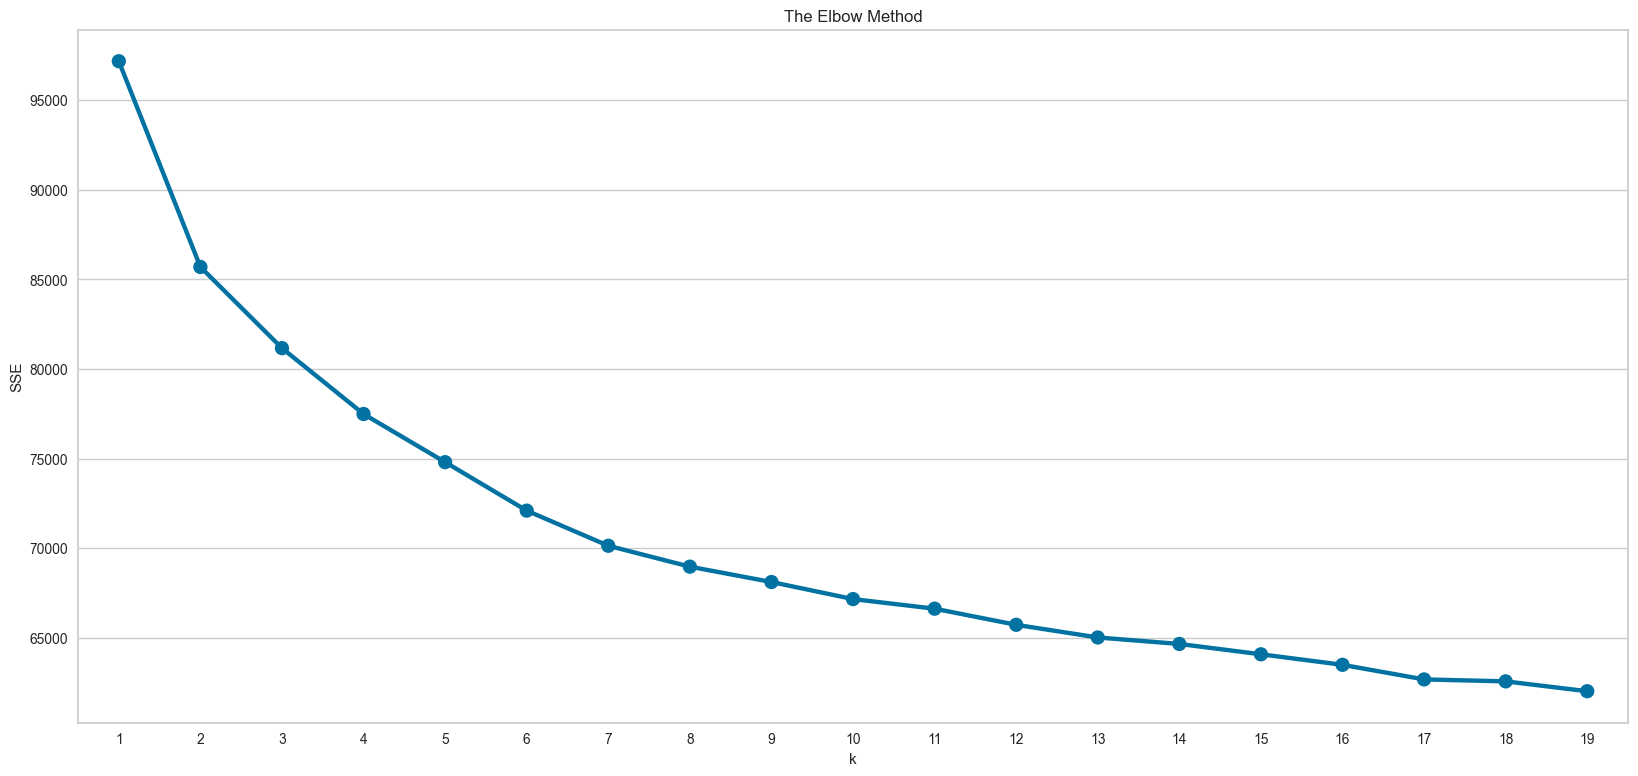

In [37]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(embeddings)
    sse[k] = kmeans.inertia_
    print(f"SSE for k={k}: {kmeans.inertia_}")  # Print the SSE score for the current k

# Plotting the SSE values
plt.figure(figsize=(20, 9))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

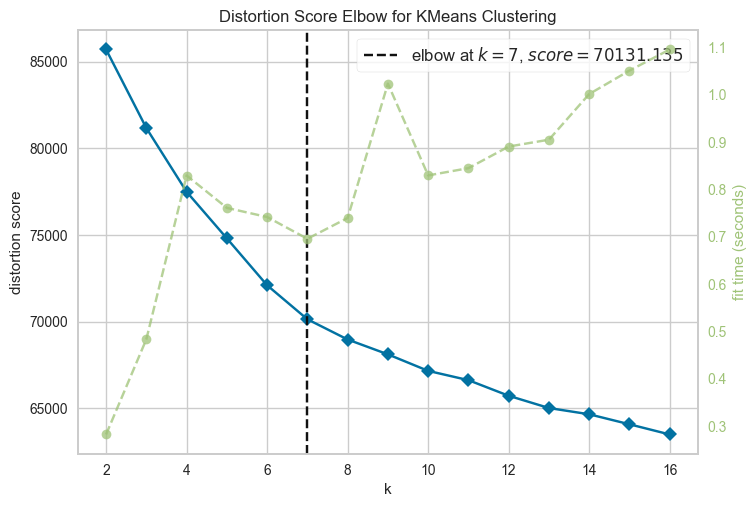

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# Assuming cmt_embeddings is your dataset
km_sse = KMeans(init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
visualizer_sse = KElbowVisualizer(km_sse, k=(2,17))
visualizer_sse.fit(embeddings)  # Fit the data to the visualizer
visualizer_sse.show()               # Display the plot


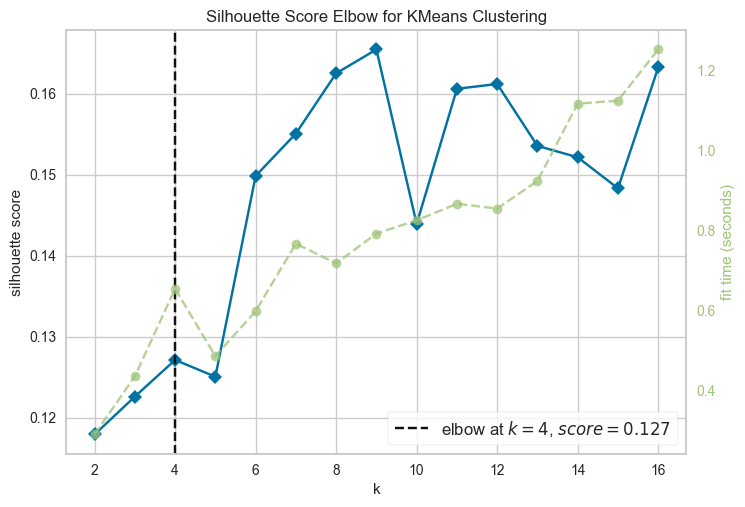

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [39]:
km_silhouette = KMeans(init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
visualizer_sil = KElbowVisualizer(km_silhouette, k=(2,17), metric='silhouette')
visualizer_sil.fit(embeddings)  # Fit the data to the visualizer
visualizer_sil.show()               # Display the plot


thì cũng khó giải thích nhma t sẽ chọn 7 cụm nhé :v ko thích thì đổi

rảnh lên tìm hiểu hai chỉ số thường được sử dụng để đánh giá chất lượng của các cụm là Distortion Score và Silhouette Score.

In [40]:
n_clusters = 7
vectorizer_model = CountVectorizer(min_df=0.10, max_df=0.90)
# cluster_model = HDBSCAN(metric='euclidean', prediction_data=True)
cluster_model = KMeans(n_clusters=n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
umap_model = umap.UMAP(n_neighbors=30, n_components=10, metric='cosine', low_memory=False, random_state=0)

topic_model = BERTopic(umap_model=umap_model, language=None,
                        hdbscan_model=cluster_model, 
                        top_n_words = 30, 
                        embedding_model=sentence_model,
                        vectorizer_model=vectorizer_model,
                        calculate_probabilities=True)

df_comments['topic'], probs = topic_model.fit_transform(sentences, embeddings)


In [41]:
# n_clusters = 4
# umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# vectorizer_model = CountVectorizer(min_df=0.10, max_df=0.90)

# cluster_model = KMeans(n_clusters=n_clusters, random_state=42)
# topic_model = BERTopic(hdbscan_model=cluster_model, 
#                        umap_model= umap_model,
#                        embedding_model=sentence_model,
#                         top_n_words=50, low_memory=True,nr_topics=n_clusters)

# df_comments['topic'], probabilities = topic_model.fit_transform(df_comments["content"], embeddings=embeddings)


In [42]:
topic_model.visualize_barchart(custom_labels=True, width=400)


In [43]:

def create_wordcloud(model, n_clusters):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))

    for i in range(2):
        for j in range(4):
            ax = axes[i, j]
            n = i * 4 + j

            if n < n_clusters:
                text = {word: value for word, value in model.get_topic(n)}
                wc = WordCloud(background_color="white", max_words=1000)
                wc.generate_from_frequencies(text)
                ax.imshow(wc, interpolation="bilinear")
                ax.axis("off")
                ax.set_title(f'Topic {n+1}')

            else:
                ax.axis('off')
                ax.set_title('')

    plt.tight_layout()
    plt.show()


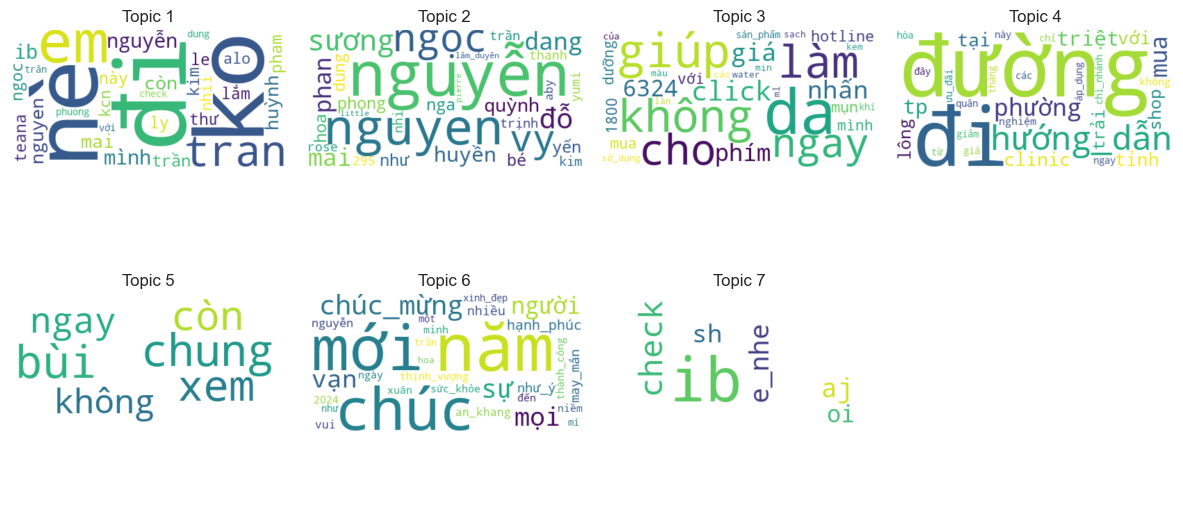

In [44]:
create_wordcloud(topic_model, 7)


In [45]:
topic_model.get_topic_info()

Topic  Count                         Name  \
0      0    348                0_đi_ko_nè_em   
1      1    341      1_nguyễn_nguyen_ngọc_vy   
2      2    220          2_da_giúp_không_làm   
3      3    211  3_đường_đi_hướng_dẫn_phường   
4      4    162          4_bùi_chung_xem_còn   
5      5    133     5_năm_mới_chúc_chúc_mừng   
6      6     69          6_ib_check_e_nhe_aj   

                                      Representation  \
0  [đi, ko, nè, em, tran, nguyễn, ib, mình, còn, ...   
1  [nguyễn, nguyen, ngọc, vy, sương, đỗ, dang, ma...   
2  [da, giúp, không, làm, cho, ngay, click, nhấn,...   
3  [đường, đi, hướng_dẫn, phường, mua, triệt, tp,...   
4  [bùi, chung, xem, còn, ngay, không, , , , , , ...   
5  [năm, mới, chúc, chúc_mừng, sự, mọi, vạn, ngườ...   
6  [ib, check, e_nhe, aj, sh, oi, , , , , , , , ,...   

                                 Representative_Docs  
0       [ib em, ib em với, thảo ngân trần mai đi ko]  
1  [đáp_án 13 + 362 bảo minh ngọc trâm nguyễn thị...  
2  [smoothie tẩy da chết dove hương lựu đỏ 298 g ...  
3  [⏰ duy_nhất khung giờ - từ ngày / / - 300 mặt_...  
4                 [còn không, chung bùi, xem ngay :]  
5  [8 - 3 - 6 7 - 2 - 5 4 - 1 - 9 số may_mắn : 24...  
6                                       [ib, ib, ib]

In [46]:
topic_model.visualize_heatmap()

In [47]:
topic_model.get_document_info(sentences)


Document  Topic  \
0     : 2203 hùng vương , phường cam lợi , tp . cam ...      3   
1                     mua ở tại cửa_hàng giá này ko ạ ?      3   
2                                        đỗ huỳnh ái my      1   
3                                                     .      4   
4                                                     .      4   
...                                                 ...    ...   
1479  đường 1 - skin1004 tinh_chất madagascar centel...      2   
1480   đường số 1 + 619 huỳnh thắmtrung hậunguyễn hoàng      1   
1481  đường số 1 + kem chống nắng dr . g + 775 mai h...      2   
1482                                            cẩm_hoa      1   
1483                              mẫu này không shop ơi      3   

                             Name  \
0     3_đường_đi_hướng_dẫn_phường   
1     3_đường_đi_hướng_dẫn_phường   
2         1_nguyễn_nguyen_ngọc_vy   
3             4_bùi_chung_xem_còn   
4             4_bùi_chung_xem_còn   
...                           ...   
1479          2_da_giúp_không_làm   
1480      1_nguyễn_nguyen_ngọc_vy   
1481          2_da_giúp_không_làm   
1482      1_nguyễn_nguyen_ngọc_vy   
1483  3_đường_đi_hướng_dẫn_phường   

                                         Representation  \
0     [đường, đi, hướng_dẫn, phường, mua, triệt, tp,...   
1     [đường, đi, hướng_dẫn, phường, mua, triệt, tp,...   
2     [nguyễn, nguyen, ngọc, vy, sương, đỗ, dang, ma...   
3     [bùi, chung, xem, còn, ngay, không, , , , , , ...   
4     [bùi, chung, xem, còn, ngay, không, , , , , , ...   
...                                                 ...   
1479  [da, giúp, không, làm, cho, ngay, click, nhấn,...   
1480  [nguyễn, nguyen, ngọc, vy, sương, đỗ, dang, ma...   
1481  [da, giúp, không, làm, cho, ngay, click, nhấn,...   
1482  [nguyễn, nguyen, ngọc, vy, sương, đỗ, dang, ma...   
1483  [đường, đi, hướng_dẫn, phường, mua, triệt, tp,...   

                                    Representative_Docs  \
0     [⏰ duy_nhất khung giờ - từ ngày / / - 300 mặt_...   
1     [⏰ duy_nhất khung giờ - từ ngày / / - 300 mặt_...   
2     [đáp_án 13 + 362 bảo minh ngọc trâm nguyễn thị...   
3                    [còn không, chung bùi, xem ngay :]   
4                    [còn không, chung bùi, xem ngay :]   
...                                                 ...   
1479  [smoothie tẩy da chết dove hương lựu đỏ 298 g ...   
1480  [đáp_án 13 + 362 bảo minh ngọc trâm nguyễn thị...   
1481  [smoothie tẩy da chết dove hương lựu đỏ 298 g ...   
1482  [đáp_án 13 + 362 bảo minh ngọc trâm nguyễn thị...   
1483  [⏰ duy_nhất khung giờ - từ ngày / / - 300 mặt_...   

                                            Top_n_words  \
0     đường - đi - hướng_dẫn - phường - mua - triệt ...   
1     đường - đi - hướng_dẫn - phường - mua - triệt ...   
2     nguyễn - nguyen - ngọc - vy - sương - đỗ - dan...   
3     bùi - chung - xem - còn - ngay - không -  -  -...   
4     bùi - chung - xem - còn - ngay - không -  -  -...   
...                                                 ...   
1479  da - giúp - không - làm - cho - ngay - click -...   
1480  nguyễn - nguyen - ngọc - vy - sương - đỗ - dan...   
1481  da - giúp - không - làm - cho - ngay - click -...   
1482  nguyễn - nguyen - ngọc - vy - sương - đỗ - dan...   
1483  đường - đi - hướng_dẫn - phường - mua - triệt ...   

      Representative_document  
0                       False  
1                       False  
2                       False  
3                       False  
4                       False  
...                       ...  
1479                    False  
1480                    False  
1481                    False  
1482                    False  
1483                    False  

[1484 rows x 7 columns]

In [48]:
topic_model.visualize_topics(top_n_topics=8,custom_labels=False,width=800,height=500)

In [49]:
topic_model.visualize_hierarchy()

## Negative cmt

In [50]:
df_comments_neg = df_comments[df_comments['sentiment'] =='negative']

In [51]:
sentences = [tokenize(sentence) for sentence in df_comments_neg['content']]
embeddings = sentence_model.encode(sentences)

# joblib.dump(embeddings, 'Assets/cmt_embeddings_neg_phobert.pkl')
# joblib.dump(sentences, 'Assets/sentences_neg_phobert.pkl')

embeddings = joblib.load('Assets/cmt_embeddings_neg_phobert.pkl')
sentences = joblib.load('Assets/sentences_neg_phobert.pkl')

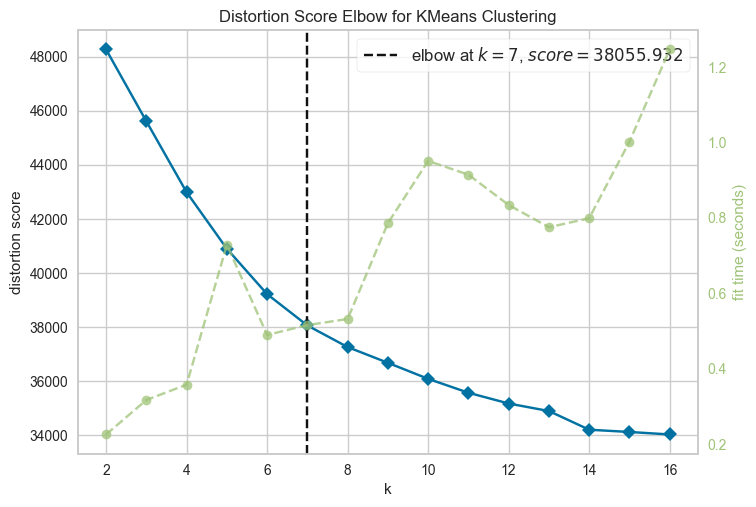

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# Assuming cmt_embeddings is your dataset
km_sse = KMeans(init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
visualizer_sse = KElbowVisualizer(km_sse, k=(2,17))
visualizer_sse.fit(embeddings)  # Fit the data to the visualizer
visualizer_sse.show()    

In [53]:
n_clusters = 7
vectorizer_model = CountVectorizer(min_df=0.10, max_df=0.90)
# cluster_model = HDBSCAN(metric='euclidean', prediction_data=True)
cluster_model = KMeans(n_clusters=n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
umap_model = umap.UMAP(n_neighbors=30, n_components=10, metric='cosine', low_memory=False, random_state=0)

topic_model = BERTopic(umap_model=umap_model, language=None,
                        hdbscan_model=cluster_model, 
                        top_n_words = 30, 
                        embedding_model=sentence_model,
                        vectorizer_model=vectorizer_model,
                        calculate_probabilities=True)

df_comments_neg['topic'], probs = topic_model.fit_transform(sentences, embeddings)



In [54]:

topic_model.visualize_barchart(custom_labels=True, width=400)


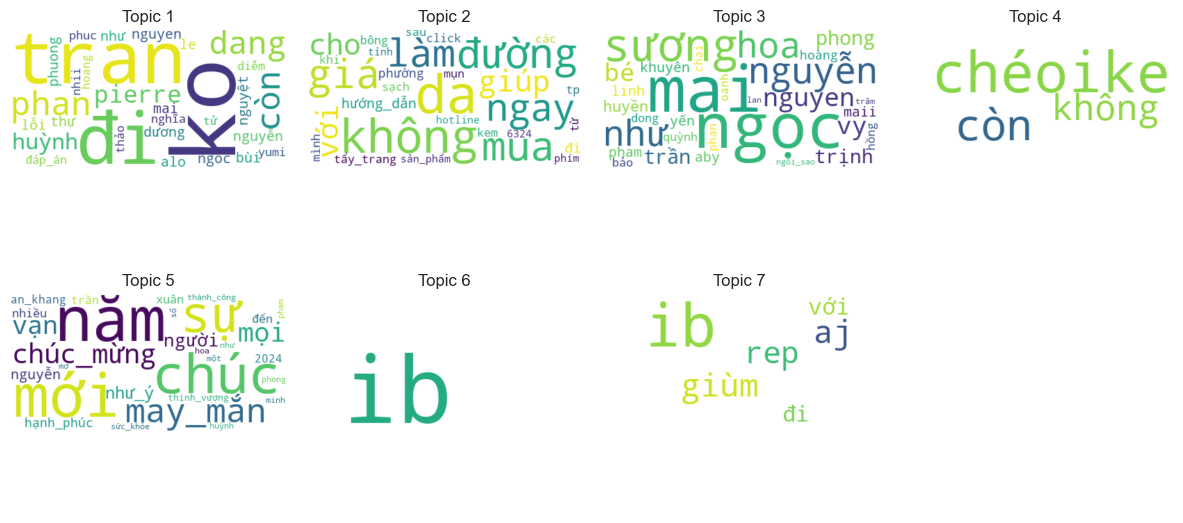

In [55]:

create_wordcloud(topic_model, 7)


## Positive cmt

In [56]:
df_comments_pos = df_comments[df_comments['sentiment'] =='positive']
# sentences = [tokenize(sentence) for sentence in df_comments_pos['content']]
# embeddings = sentence_model.encode(sentences)

# joblib.dump(embeddings, 'Assets/cmt_embeddings_pos_phobert.pkl')
# joblib.dump(sentences, 'Assets/sentences_pos_phobert.pkl')

embeddings = joblib.load('Assets/cmt_embeddings_pos_phobert.pkl')
sentences = joblib.load('Assets/sentences_pos_phobert.pkl')


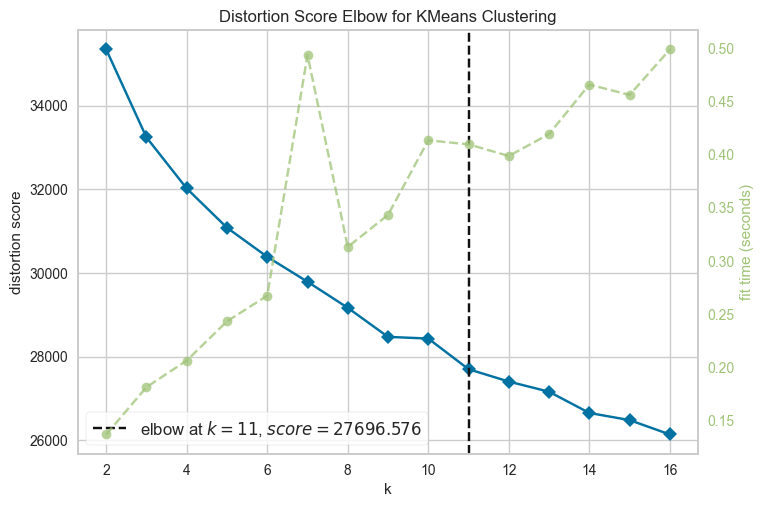

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [57]:

# Assuming cmt_embeddings is your dataset
km_sse = KMeans(init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
visualizer_sse = KElbowVisualizer(km_sse, k=(2,17))
visualizer_sse.fit(embeddings)  # Fit the data to the visualizer
visualizer_sse.show()    


In [58]:

n_clusters = 11
vectorizer_model = CountVectorizer(min_df=0.10, max_df=0.90)
# cluster_model = HDBSCAN(metric='euclidean', prediction_data=True)
cluster_model = KMeans(n_clusters=n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
umap_model = umap.UMAP(n_neighbors=30, n_components=10, metric='cosine', low_memory=False, random_state=0)

topic_model = BERTopic(umap_model=umap_model, language=None,
                        hdbscan_model=cluster_model, 
                        top_n_words = 30, 
                        embedding_model=sentence_model,
                        vectorizer_model=vectorizer_model,
                        calculate_probabilities=True)

df_comments_pos['topic'], probs = topic_model.fit_transform(sentences, embeddings)


In [59]:
topic_model.visualize_barchart(top_n_topics=11, custom_labels=True, width=400)


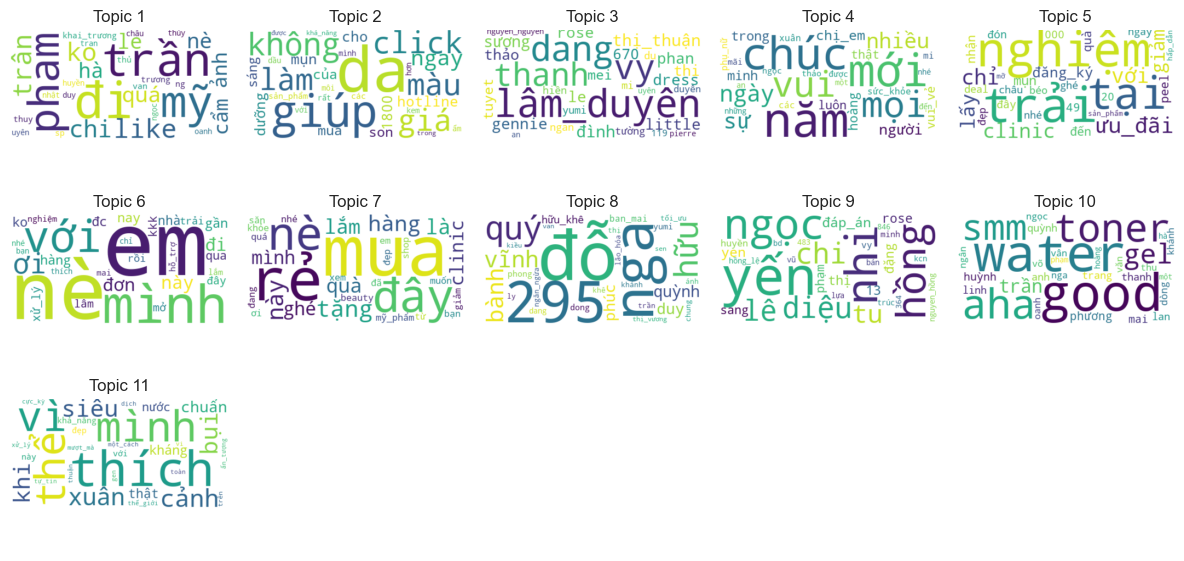

In [60]:
fig, axes = plt.subplots(3, 5, figsize=(12, 6))

for i in range(3):
    for j in range(5):
        ax = axes[i, j]
        n = i * 5 + j

        if n < n_clusters:
            text = {word: value for word, value in topic_model.get_topic(n)}
            wc = WordCloud(background_color="white", max_words=1000)
            wc.generate_from_frequencies(text)
            ax.imshow(wc, interpolation="bilinear")
            ax.axis("off")
            ax.set_title(f'Topic {n+1}')

        else:
            ax.axis('off')
            ax.set_title('')

plt.tight_layout()
plt.show()